In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])


In [3]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])


In [4]:
full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)


100%|██████████| 170M/170M [00:02<00:00, 67.8MB/s]


In [5]:
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)


In [6]:
train_size = int(0.85 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size


In [7]:
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])


In [8]:
val_dataset.dataset.transform = test_transform


In [9]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)


In [10]:
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleANN(nn.Module):
    def __init__(self):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN,self).__init__()
    self.conv=nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32,64,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fcl=nn.Sequential(
        nn.Linear(64*8*8,512),
        nn.ReLU(),
        nn.Linear(512,10)
    )

  def forward(self,x):
    x=self.conv(x)
    x=x.view(x.size(0),-1)
    x=self.fcl(x)
    return x


In [11]:
def train_model(model, train_loader, val_loader, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Validation
        model.eval()
        total_val_loss = 0
        correct, total = 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        train_losses.append(total_train_loss / len(train_loader))
        val_losses.append(total_val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, val_accuracies


# **ANN training**

In [ ]:
a_model = SimpleANN()
a_train_loss, a_val_loss, a_val_acc = train_model(a_model, train_loader, val_loader, epochs=7)


Epoch [1/7], Train Loss: 1.6605, Val Loss: 1.5279, Val Acc: 45.72%
Epoch [2/7], Train Loss: 1.4509, Val Loss: 1.4413, Val Acc: 49.43%
Epoch [3/7], Train Loss: 1.3324, Val Loss: 1.4099, Val Acc: 50.59%
Epoch [4/7], Train Loss: 1.2417, Val Loss: 1.3993, Val Acc: 51.09%
Epoch [5/7], Train Loss: 1.1514, Val Loss: 1.3844, Val Acc: 52.88%
Epoch [6/7], Train Loss: 1.0716, Val Loss: 1.4574, Val Acc: 51.59%
Epoch [7/7], Train Loss: 0.9978, Val Loss: 1.4604, Val Acc: 52.63%


In [ ]:
a_model = SimpleANN()
train_loss, val_loss, val_acc = train_model(a_model, train_loader, val_loader, epochs=12)

In [ ]:
a_model = SimpleANN()
train_loss, val_loss, val_acc = train_model(a_model, train_loader, val_loader, epochs=20)

# **CNN Training**

In [ ]:
c_model = SimpleCNN()
c_train_loss, c_val_loss, c_val_acc = train_model(c_model, train_loader, val_loader, epochs=7)

Epoch [1/7], Train Loss: 1.3174, Val Loss: 1.0498, Val Acc: 62.88%
Epoch [2/7], Train Loss: 0.9277, Val Loss: 0.9439, Val Acc: 66.92%
Epoch [3/7], Train Loss: 0.7422, Val Loss: 0.8244, Val Acc: 71.37%
Epoch [4/7], Train Loss: 0.5733, Val Loss: 0.8270, Val Acc: 71.13%
Epoch [5/7], Train Loss: 0.4147, Val Loss: 0.9023, Val Acc: 71.40%
Epoch [6/7], Train Loss: 0.2733, Val Loss: 0.9874, Val Acc: 72.19%
Epoch [7/7], Train Loss: 0.1607, Val Loss: 1.0933, Val Acc: 72.55%


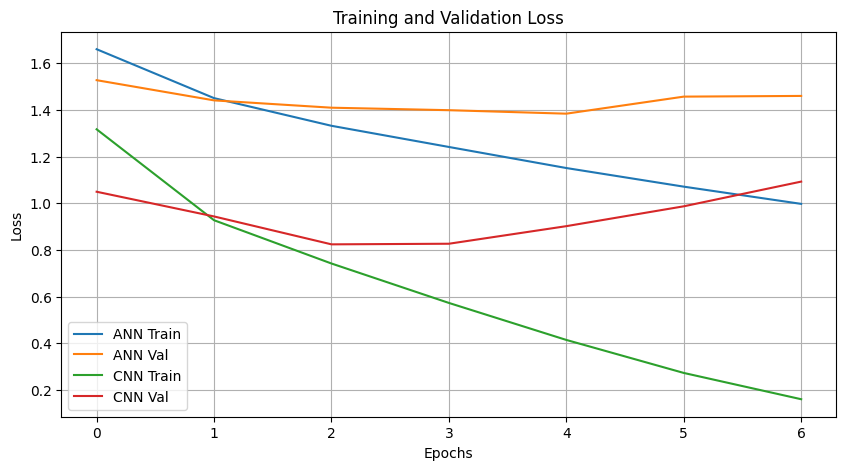

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(a_train_loss, label='ANN Train')
plt.plot(a_val_loss , label='ANN Val')
plt.plot(c_train_loss, label='CNN Train')
plt.plot(c_val_loss, label='CNN Val')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

In [ ]:
evaluate(a_model,test_loader)
evaluate(c_model,test_loader)

Test Accuracy: 51.88%
Test Accuracy: 72.38%


# **LeNet**

In [15]:
grayscale=transforms.Compose([
    transforms.Resize(32),
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [16]:
train_dataset.dataset.transform = grayscale
test_dataset.transform = grayscale
val_dataset.dataset.transform = grayscale

In [17]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [27]:
import torch.nn as nn
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet,self).__init__()
    self.conv=nn.Sequential(
        nn.Conv2d(1,6,kernel_size=5),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2,stride=2),
        nn.Conv2d(6,16,kernel_size=5),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2,stride=2),
        nn.Conv2d(16,120,kernel_size=5),
        nn.ReLU()
    )
    self.fc=nn.Sequential(
        nn.Linear(120,100),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(100,70),
        nn.ReLU(),
        nn.Dropout(0.48),
        nn.Linear(70,10)
    )

  def forward(self,x):
    x=self.conv(x)
    x=x.view(x.size(0),-1)
    x=self.fc(x)
    return x

In [28]:
lenet= LeNet()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lenet.to(device)

optimizer = torch.optim.Adam(lenet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [29]:
train_model(lenet,train_loader,val_loader,epochs=12)

Epoch [1/12], Train Loss: 1.9953, Val Loss: 1.8676, Val Acc: 30.84%
Epoch [2/12], Train Loss: 1.8059, Val Loss: 1.7447, Val Acc: 35.69%
Epoch [3/12], Train Loss: 1.7226, Val Loss: 1.6287, Val Acc: 40.97%
Epoch [4/12], Train Loss: 1.6423, Val Loss: 1.5536, Val Acc: 44.67%
Epoch [5/12], Train Loss: 1.5672, Val Loss: 1.4832, Val Acc: 47.57%
Epoch [6/12], Train Loss: 1.4999, Val Loss: 1.4260, Val Acc: 49.63%
Epoch [7/12], Train Loss: 1.4408, Val Loss: 1.4116, Val Acc: 49.47%
Epoch [8/12], Train Loss: 1.3958, Val Loss: 1.3509, Val Acc: 52.64%
Epoch [9/12], Train Loss: 1.3534, Val Loss: 1.3123, Val Acc: 53.47%
Epoch [10/12], Train Loss: 1.3176, Val Loss: 1.3023, Val Acc: 54.19%
Epoch [11/12], Train Loss: 1.2909, Val Loss: 1.2941, Val Acc: 54.69%
Epoch [12/12], Train Loss: 1.2537, Val Loss: 1.2577, Val Acc: 56.25%


([1.995331455173349,
  1.8058628376265218,
  1.7225717505118003,
  1.6423028451159485,
  1.5672341796688567,
  1.4998990352888752,
  1.4407885440310142,
  1.3958210468292236,
  1.3533514531931483,
  1.3176063034767496,
  1.290889204803266,
  1.2537144064006949],
 [1.8675627930689667,
  1.7447460617049266,
  1.6287057844258972,
  1.5535813600330028,
  1.483176444546651,
  1.4259978755045746,
  1.4115880424693479,
  1.3508975435111483,
  1.312262661881366,
  1.3022991858296475,
  1.2940604085639371,
  1.2577124409756417],
 [30.84,
  35.693333333333335,
  40.973333333333336,
  44.666666666666664,
  47.57333333333333,
  49.626666666666665,
  49.46666666666667,
  52.64,
  53.46666666666667,
  54.18666666666667,
  54.693333333333335,
  56.25333333333333])

In [30]:
eval_u(lenet,test_loader)

              precision    recall  f1-score   support

    airplane       0.60      0.56      0.58      1000
  automobile       0.72      0.68      0.70      1000
        bird       0.40      0.43      0.41      1000
         cat       0.31      0.19      0.24      1000
        deer       0.47      0.45      0.46      1000
         dog       0.45      0.55      0.49      1000
        frog       0.70      0.58      0.64      1000
       horse       0.64      0.65      0.65      1000
        ship       0.59      0.78      0.67      1000
       truck       0.59      0.67      0.63      1000

    accuracy                           0.55     10000
   macro avg       0.55      0.55      0.55     10000
weighted avg       0.55      0.55      0.55     10000

Confusion Matrix:
[[563  27 150   9  36  12  10  15 138  40]
 [ 22 676   4  23  15   7  23   8  80 142]
 [ 99  11 429  59 108 145  45  30  43  31]
 [ 27  20 117 190 115 259  69  57  69  77]
 [ 50  13 164  57 454  64  47 104  30  17]
 [ 17   

# **resnet**

In [ ]:
new_transform= transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset.dataset.transform = new_transform
test_dataset.transform = new_transform
val_dataset.dataset.transform = new_transform

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
import torchvision.models as models
res50=models.resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 204MB/s]


In [ ]:
for name,par in res50.named_parameters():
  if "layer4" in name or "fc" in name:
    par.requires_grad=True
  else:
    par.requires_grad=False

In [ ]:
res50.fc=nn.Sequential(
    nn.Linear(2048,512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512,10)
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
res50.to(device)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, res50.parameters()), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [12]:
def eval_u(model,test_loader):
  model.eval()
  y_pred,y_true=[],[]

  for images,labels in test_loader:
    images,labels=images.to(device),labels.to(device)
    outputs=model(images)
    _,predicted=torch.max(outputs,1)
    y_pred.extend(predicted.cpu().numpy())
    y_true.extend(labels.cpu().numpy())

  print(classification_report(y_true, y_pred, target_names=test_loader.dataset.classes))
  print("Confusion Matrix:")
  print(confusion_matrix(y_true, y_pred))

In [ ]:
res50_t=train_model(res50,train_loader,val_loader,epochs=10)

Epoch [1/10], Train Loss: 0.5661, Val Loss: 0.3519, Val Acc: 88.64%
Epoch [2/10], Train Loss: 0.3271, Val Loss: 0.3439, Val Acc: 88.91%
Epoch [3/10], Train Loss: 0.2112, Val Loss: 0.3837, Val Acc: 87.84%
Epoch [4/10], Train Loss: 0.1476, Val Loss: 0.3907, Val Acc: 89.41%
Epoch [5/10], Train Loss: 0.1321, Val Loss: 0.3513, Val Acc: 90.16%
Epoch [6/10], Train Loss: 0.0995, Val Loss: 0.3364, Val Acc: 90.65%
Epoch [7/10], Train Loss: 0.0576, Val Loss: 0.3672, Val Acc: 90.97%
Epoch [8/10], Train Loss: 0.0585, Val Loss: 0.5076, Val Acc: 88.59%
Epoch [9/10], Train Loss: 0.0585, Val Loss: 0.4100, Val Acc: 90.48%
Epoch [10/10], Train Loss: 0.0392, Val Loss: 0.4746, Val Acc: 89.76%


In [ ]:
eval_u(res50,test_loader)

              precision    recall  f1-score   support

    airplane       0.93      0.88      0.91      1000
  automobile       0.95      0.95      0.95      1000
        bird       0.80      0.92      0.85      1000
         cat       0.89      0.71      0.79      1000
        deer       0.91      0.84      0.88      1000
         dog       0.88      0.78      0.83      1000
        frog       0.91      0.95      0.93      1000
       horse       0.80      0.97      0.88      1000
        ship       0.91      0.95      0.93      1000
       truck       0.95      0.93      0.94      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Confusion Matrix:
[[877   5  25   9   1   0   1  20  54   8]
 [  3 954   1   1   0   0   1   5   7  28]
 [ 16   0 924   8  16   4  10  17   5   0]
 [  4   2  69 712  18  90  34  59   9   3]
 [  6   0  48   8 844   7  30  50   6   1]
 [  0   

#**resnet152**

In [ ]:
res152=models.resnet152(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 94.2MB/s] 


In [ ]:
for name,par in res152.named_parameters():
    if "layer4" in name or "fc" in name:
        par.requires_grad=True
    else:
        par.requires_grad=False

In [ ]:
res152.fc=nn.Sequential(
    nn.Linear(2048,512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512,10)
)

In [ ]:
res152.to(device)
train_model(res152,train_loader,val_loader,epochs=7)

Epoch [1/7], Train Loss: 0.4913, Val Loss: 0.3238, Val Acc: 89.05%
Epoch [2/7], Train Loss: 0.2675, Val Loss: 0.2816, Val Acc: 90.37%
Epoch [3/7], Train Loss: 0.1727, Val Loss: 0.2506, Val Acc: 91.77%
Epoch [4/7], Train Loss: 0.1211, Val Loss: 0.3398, Val Acc: 90.75%
Epoch [5/7], Train Loss: 0.0987, Val Loss: 0.3154, Val Acc: 91.13%
Epoch [6/7], Train Loss: 0.0610, Val Loss: 0.3005, Val Acc: 92.56%
Epoch [7/7], Train Loss: 0.0469, Val Loss: 0.3721, Val Acc: 91.21%


([0.4912967299944476,
  0.26746040161951146,
  0.1727206695404716,
  0.12107353486484827,
  0.09872492675326372,
  0.06097338451597756,
  0.04688013462696392],
 [0.32379909844721777,
  0.2815564856312032,
  0.25056739069395145,
  0.3398148565221641,
  0.3153628283890627,
  0.3005158313060716,
  0.37207054432039544],
 [89.05333333333333,
  90.37333333333333,
  91.77333333333333,
  90.74666666666667,
  91.13333333333334,
  92.56,
  91.21333333333334])

In [ ]:
eval_u(res152,test_loader)

              precision    recall  f1-score   support

    airplane       0.91      0.91      0.91      1000
  automobile       0.98      0.89      0.93      1000
        bird       0.93      0.90      0.92      1000
         cat       0.83      0.86      0.84      1000
        deer       0.90      0.94      0.92      1000
         dog       0.92      0.84      0.88      1000
        frog       0.94      0.95      0.95      1000
       horse       0.92      0.94      0.93      1000
        ship       0.98      0.89      0.93      1000
       truck       0.82      0.99      0.90      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Confusion Matrix:
[[909   1   9   5   5   0   4   7  12  48]
 [  4 887   2   6   0   0   2   1   0  98]
 [ 16   0 902  20  26   6  20   6   2   2]
 [  5   1  20 859  28  45  16  17   2   7]
 [  2   0  11  11 940   3   9  24   0   0]
 [  1   